In [2]:
import tensorflow as tf
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from datetime import datetime
import utils_optim1
import model1
import results_generator
importlib.reload(utils_optim1)
importlib.reload(model1)
importlib.reload(results_generator)
from utils_optim1 import *
from model1 import *
from results_generator import *
tf.test.is_built_with_cuda()

True

In [3]:
# This code is only needed if the dataset is stored in google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Check if gpu exists
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# This code is only needed if the dataset is stored in google drive and it is 7z compressed
!p7zip -d /content/gdrive/MyDrive/Thesis/Sketch-Icon-Dataset.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/MyDrive/Thesis/                                         1 file, 263683120 bytes (252 MiB)

Extracting archive: /content/gdrive/MyDrive/Thesis/Sketch-Icon-Dataset.7z
--
Path = /content/gdrive/MyDrive/Thesis/Sketch-Icon-Dataset.7z
Type = 7z
Physical Size = 263683120
Headers Size = 344455
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      1% 952 - Sketch-Icon-Dataset/icon/mathematics/wave-square.jpg                                                                 2% 1457 - Sketch-Icon-Dataset/sketch/accessibility/low-visio

In [5]:
icon_name_category, sketch_name_category = get_icons_and_sketches()

In [6]:
# Split the dataset into train and test with randomness
# or load the train and test dataset which is created as numpy arrays.
# The purpose of the predefined datasets is to have the same datasets for training
# the classification of sketches and the sketch-icon retrieval, so the test set will be the same,
# and unknown for both trainings
random_generation = False
if random_generation:
  positive_pairs = positive_pairs_generator(icon_name_category, sketch_name_category)
  positive_pairs = shuffle(positive_pairs)

  len_data = len(positive_pairs)
  p_train=0.9
  p_test=0.1
  num_train = int(np.ceil(len_data*p_train))
  num_test = int(np.floor(len_data*p_test))

  positive_pairs_Train = positive_pairs[:num_train]
  possible_negative_pairs_Train = possible_negative_pairs_generator(positive_pairs_Train, icon_name_category)

  positive_pairs_Test = positive_pairs[-num_test:]
  sketches_Test = positive_pairs_Test[:, [0, 1]]

  icons_Test = positive_pairs_Test[:, [2, 3]]
  # create the icons test dataset by removing the dublicates of the array
  _, unique_indices = np.unique(icons_Test[:,0], return_index=True)
  unique_icons_Test = icons_Test[unique_indices]

  print(f'We have {len(positive_pairs_Train)} samples in the training set.')
  print(f'We have {len(sketches_Test)} sketches in the test set.')
  print(f'We have {len(unique_icons_Test)} unique icons in the test set.')
else:
  sketch_name_category_Train = load_train_set()
  sketch_name_category_Test = load_test_set()

  positive_pairs_Train =  positive_pairs_generator(icon_name_category, sketch_name_category_Train)
  possible_negative_pairs_Train = possible_negative_pairs_generator(positive_pairs_Train, icon_name_category)

  positive_pairs_Test =  positive_pairs_generator(icon_name_category, sketch_name_category_Test)

  sketches_Test = positive_pairs_Test[:, [0, 1]]

  icons_Test = positive_pairs_Test[:, [2, 3]]
  
  # create the icons test dataset by removing the dublicates of the array
  _, unique_indices = np.unique(icons_Test[:,0], return_index=True)
  unique_icons_Test = icons_Test[unique_indices]

  print(f'We have {len(positive_pairs_Train)} samples in the training set.')
  print(f'We have {len(sketches_Test)} sketches in the test set.')
  print(f'We have {len(unique_icons_Test)} unique icons in the test set.')


We have 28626 samples in the training set.
We have 3180 sketches in the test set.
We have 1178 unique icons in the test set.


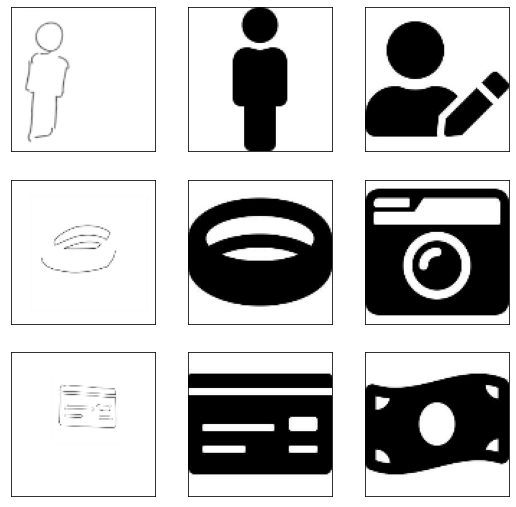

In [7]:
BATCH_SIZE = 256

def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

train_dataset = generate_Train_dataset(positive_pairs_Train, icon_name_category, possible_negative_pairs_Train, BATCH_SIZE)

sketch_dataset_Test, icon_dataset_Test = generate_Test_sets(sketches_Test, unique_icons_Test, BATCH_SIZE)

visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [10]:
choices = ["Triplet Loss", "Triplet Loss-CWI"] # CWI = Classification Weights Initialization
model_name = "MyNet"
create_directory(model_name + "/")
now = datetime.now()
date_time_folder = now.strftime("%d-%m-%Y %H-%M-%S")
train_weights_folder = "Train Weights"
choice = 0

# choice 0 is the triplet loss without initialization of classification weights - one model (mynet) with shared weights
# choice 1 is the triplet loss without initialization of classification weights - two models (mynet) initialized classification weights and update with the same grads
if choice == 0:
  # Creation of folders for storing stats, weights and the hyperparameters of the model
  create_directory(model_name + "/" + choices[choice])
  current_run_path = model_name + "/" + choices[choice] + "/" + date_time_folder + "/"
  create_directory(current_run_path)
  train_weights_path = model_name + "/" + choices[choice] + "/" + date_time_folder + "/" + train_weights_folder
  create_directory(train_weights_path)
  #=====================================================================================

  # Hyperparameter initializations
  num_epochs = 1000
  margin = 1
  learning_rate = 0.0001

  # Store the hyperparameters of the model into a file to remember what I used in a specific run
  write_hyperparameters_in_file(current_run_path, learning_rate, BATCH_SIZE, margin)
  
  # Initializations of optimizer, loss and network and set the backend (model variables) to float32
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  tf.keras.backend.set_floatx('float32')
  tripleModel = mynet()
  loss = triplet_loss

  # Function which is responsible to calculate the loss and update the grads
  def train_step(sketches, positive_icons, negative_icons, margin):
      with tf.GradientTape() as tape:
          sketch_features,_ = tripleModel(sketches, training = True)
          icon_positive_features,_ = tripleModel(positive_icons, training = True) 
          icon_negative_features,_ = tripleModel(negative_icons, training = True)   
          tape.watch(sketch_features)
          tape.watch(icon_positive_features)
          tape.watch(icon_negative_features)
          current_loss = loss(sketch_features, icon_positive_features, icon_negative_features, margin)
      grads = tape.gradient(current_loss, tripleModel.trainable_variables)
      optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, tripleModel.trainable_variables) if grad is not None)
      return current_loss

elif choice == 1:
  # Creation of folders for storing stats, weights and the hyperparameters of the model
  create_directory(model_name + "/" + choices[choice])
  current_run_path = model_name + "/" + choices[choice] + "/" + date_time_folder + "/"
  create_directory(current_run_path)
  train_weights_path = model_name + "/" + choices[choice] + "/" + date_time_folder + "/" + train_weights_folder
  create_directory(train_weights_path)
  #=====================================================================================

  # Hyperparameter initializations
  num_epochs = 1000
  margin = 1
  learing_rate = 0.0001

  # Store the hyperparameters of the model into a file to remember what I used in a specific run
  write_hyperparameters_in_file(current_run_path, learing_rate, BATCH_SIZE, margin)

  # Initializations of optimizer, loss and network and set the backend (model variables) to float32
  optimizer = tf.keras.optimizers.Adam(learing_rate)
  tf.keras.backend.set_floatx('float32')
  weights_path_sketch = "/content/gdrive/MyDrive/Thesis/MyNet/Sketch Classification/24-03-2021 17-39-23/Train Weights/"
  weights_path_icon = "/content/gdrive/MyDrive/Thesis/MyNet/Icon Classification/24-03-2021 17-34-23/Train Weights/"
  iconClassificationModel = mynet(NUM_CLASSES=66)
  iconClassificationModel.load_weights(weights_path_icon + 'iconClassification')
  sketchClassificationModel = mynet(NUM_CLASSES=66)
  sketchClassificationModel.load_weights(weights_path_sketch + 'sketchClassification')
  loss = triplet_loss

  # Function which is responsible to calculate the loss and update the grads
  def train_step(sketches, positive_icons, negative_icons, margin):
      with tf.GradientTape(persistent=True) as tape:
          sketch_features,_ = sketchClassificationModel(sketches, training = True)
          icon_positive_features,_ = iconClassificationModel(positive_icons, training = True)
          icon_negative_features,_ = iconClassificationModel(negative_icons, training = True)   
          tape.watch(sketch_features)
          tape.watch(icon_positive_features)
          tape.watch(icon_negative_features)
          current_loss = loss(sketch_features, icon_positive_features, icon_negative_features, margin)
      grads = tape.gradient(current_loss, sketchClassificationModel.trainable_variables)
      optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, sketchClassificationModel.trainable_variables) if grad is not None)
      grads = tape.gradient(current_loss, iconClassificationModel.trainable_variables)
      optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, iconClassificationModel.trainable_variables) if grad is not None)
      return current_loss

Creation of the directory  failedMyNet/
Successfully created the directory  MyNet/Triplet Loss
Successfully created the directory  MyNet/Triplet Loss/13-04-2021 12-39-11/
Successfully created the directory  MyNet/Triplet Loss/13-04-2021 12-39-11/Train Weights


In [ ]:
import time
top_acc = 0
top_acc1 = 0
top_acc10 = 0

for epoch in range(num_epochs):

    # Training loop throught the training dataset
    epoch_loss_avg = tf.keras.metrics.Mean()
    start_time = time. time()
    for sketches, positive_icons, negative_icons in train_dataset:
        loss_value = train_step(sketches, positive_icons, negative_icons, margin)
        epoch_loss_avg.update_state(loss_value)
    print("Epoch {:d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))

    if epoch%1==0:
      # Test loop through the test datatet
        acc_1 = 0
        acc_10 = 0

        # extract features for sketches
        sketch_representations = []
        for batch_sketches in sketch_dataset_Test:
            if choice == 0:
              sketch_repr,_ =  tripleModel(batch_sketches, training = False)
            elif choice == 1:
              sketch_repr,_ =  sketchClassificationModel(batch_sketches, training = False)
            sketch_representations.append(sketch_repr)
        sketch_representations = np.vstack(sketch_representations)

        # extract features for icons
        icon_representations = []
        for batch_icons in icon_dataset_Test:
            if choice == 0:
              icons_repr,_ =  tripleModel(batch_icons, training = False)
            elif choice == 1:
              icons_repr,_ =  iconClassificationModel(batch_icons, training = False)
            icon_representations.append(icons_repr)
        icon_representations = np.vstack(icon_representations)

        # check using euclidean distance the top 1 and top 10 accuracy
        for k in range(len(sketch_representations)):
            sketch_repr = sketch_representations[k]
            sketch_representations_tile = np.tile(sketch_repr, len(unique_icons_Test)).reshape(len(unique_icons_Test), 64)
            diff = np.sqrt(np.mean((sketch_representations_tile - icon_representations)**2, -1))
            top_k = np.argsort(diff)[:10]
            
            for j in range(len(top_k)):
                index = top_k[j]
                if j == 0 and sketches_Test[k][0].split("_")[0] == unique_icons_Test[index][0].replace(".jpg",""):
                    acc_1 = acc_1 + 1
                    acc_10 = acc_10 + 1
                    break
                elif sketches_Test[k][0].split("_")[0] == unique_icons_Test[index][0].replace(".jpg",""):
                    acc_10 = acc_10 + 1
                    break
        if top_acc < acc_1 + acc_10:
          if choice == 0:
            save_weights(tripleModel, train_weights_path + "/TripletWithCWI")
          elif choice == 1:
            save_weights(iconClassificationModel, train_weights_path + "/iconTripletWithCWI")
            save_weights(sketchClassificationModel, train_weights_path + "/sketchTripletWithCWI")
          top_acc = acc_1 + acc_10
          top_acc1 = acc_1
          top_acc10 = acc_10
        print("Accuracy of top 1: " + str(acc_1/len(sketches_Test)))
        print("Accuracy of top 10: " + str(acc_10/len(sketches_Test)))
        write_triplet_stats_in_file(current_run_path, epoch, epoch_loss_avg.result(), acc_1/len(sketches_Test), acc_10/len(sketches_Test))

    train_dataset = generate_Train_dataset(positive_pairs_Train, icon_name_category, possible_negative_pairs_Train, BATCH_SIZE)
    current_time = time. time()
    elapsed_time = current_time - start_time
    print("Finished iterating in: " + str(int(elapsed_time)) + " seconds")

Epoch 0: Loss: 1008.128
Accuracy of top 1: 0.0015723270440251573
Accuracy of top 10: 0.009119496855345912
Finished iterating in: 101 seconds
